# Loading data and traing a viral classifier on metagenomic sequences of mosquitoes

## Import dependencies 

In [1]:
import pandas as pd 
import numpy as np 

from torchmetagen.datasets.utils import FastaHandler, DatasetSplit, InflateDataset
from torchmetagen.datasets import metagenomicdataset as meta
from torchmetagen.models import DeepVirFinder, deepvirfinder
from torchmetagen.transforms import *
from torchvision import transforms as tf
import torch

from utils import *

## Check for GPU devices

In [2]:
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
path_to_file = 'Dataset_v1_2'

viral = FastaHandler(path_to_file, 'viral.fasta',)
nonviral= FastaHandler(path_to_file, 'nonviral.fasta',)



In [4]:
splitter = DatasetSplit({'train':0.7,'val':0.3 })

viral_train, viral_test= splitter(viral)
nonviral_train, nonviral_test= splitter(nonviral)


In [5]:

inflate=InflateDataset(method='truncated', tol=0.5, chunk_size=500)

viral_train_inflated = viral_train#inflate(viral_train)
viral_test_inflated = viral_test #inflate(viral_test)


nonviral_train_inflated =  nonviral_train#inflate(nonviral_train)
nonviral_test_inflated = nonviral_test#inflate(nonviral_test)

In [24]:
transforms_train=tf.Compose([
    ReverseComplement(),
    # ToOneHot(['G','T', 'C', 'A']),
    # ToTensor('one-hot')
    ToKmer(),
    ToTensor()
])

transforms_test=tf.Compose([
    ReverseComplement(),
    # ToOneHot(['G','T', 'C', 'A']),
    # ToTensor('one-hot')
    ToKmer(),
    ToTensor()
])


dataset_train= meta.MetagenomicSequenceData(pd.DataFrame({"data":np.concatenate((nonviral_train_inflated, viral_train_inflated)),
                                                          "class":np.concatenate((np.repeat("nonviral",len(nonviral_train_inflated)),
                                                                                  np.repeat("viral",len(viral_train_inflated))))}),
                                                     labels=['nonviral', 'viral'], transform=transforms_train)

dataset_test= meta.MetagenomicSequenceData(pd.DataFrame({"data":np.concatenate((nonviral_test_inflated, viral_test_inflated)),
                                                         "class":np.concatenate((np.repeat("nonviral",len(nonviral_test_inflated)),
                                                                                 np.repeat("viral",len(viral_test_inflated))))}),
                                                     labels=['nonviral', 'viral'], transform=transforms_test)

dataset={'train': dataset_train, 'val': dataset_test}
dataset_sizes = {'train':len(dataset_train), 'val':len(dataset_test)}

In [25]:
dataloaders = genDataLoader(dataset, {'train':256, 'val':64})

In [26]:
dataloaders['train'].dataset[10]



((tensor([0.0226, 0.0238, 0.0203, 0.0232, 0.0000, 0.0179, 0.0262, 0.0137, 0.0161,
          0.0000, 0.0125, 0.0167, 0.0203, 0.0131, 0.0000, 0.0250, 0.0155, 0.0167,
          0.0083, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0256, 0.0155,
          0.0149, 0.0209, 0.0000, 0.0280, 0.0298, 0.0244, 0.0143, 0.0000, 0.0161,
          0.0185, 0.0167, 0.0113, 0.0000, 0.0131, 0.0191, 0.0095, 0.0060, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0185, 0.0155, 0.0137, 0.0054,
          0.0000, 0.0185, 0.0203, 0.0143, 0.0137, 0.0000, 0.0167, 0.0203, 0.0274,
          0.0155, 0.0000, 0.0191, 0.0072, 0.0077, 0.0095, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0232, 0.0185, 0.0137, 0.0161, 0.0000, 0.0125,
          0.0203, 0.0107, 0.0036, 0.0000, 0.0077, 0.0113, 0.0155, 0.0036, 0.0000,
          0.0143, 0.0054, 0.0042, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000

In [27]:
model_torch = deepvirfinder(pretrained=False, progress=True, M = 1000, K = 10, N = 1000)


In [28]:

#device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model_torch.parameters(), lr = 1e-4)
criterion = torch.nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,4)
per_epoch, per_batch = train_model(model_torch.to(device), criterion, optimizer, 
                      scheduler, dataloaders, device, dataset_sizes, num_epochs=1)

Epoch 0/0
----------


RuntimeError: Given groups=1, weight of size [1000, 4, 10], expected input[1, 256, 125] to have 4 channels, but got 256 channels instead

In [10]:


pd.DataFrame(evaluate(model_torch.to(device), dataloaders['val'], device))


Acc test_set: 0.8335


,0,1,accuracy,macro avg,weighted avg
precision,0.834842,0.250000,0.833521,0.542421,0.738138
recall,0.997972,0.003413,0.833521,0.500692,0.833521
f1-score,0.909147,0.006734,0.833521,0.457940,0.759933
support,1479.000000,293.000000,0.833521,1772.000000,1772.000000


In [24]:
from itertools import product

k = 3
stride = 1

contig = viral_train[0]
def _k_mer_iter(contig, k, stride) :
    for idx in range(0, len(contig) -k + 1,stride): yield contig[idx:idx + k ] 

kmer_list =[''.join(x) for x in  product('ACTGN', repeat= k )]
kmer_extracted = list(_k_mer_iter(contig, k, stride))



In [25]:
kmer_list = pd.DataFrame(data=kmer_list, columns=['KMER'])
kmer_extracted = pd.DataFrame(kmer_extracted, columns=['KMER'])
n_kmers = kmer_extracted.shape[0]
kmer_extracted = kmer_extracted.groupby('KMER').agg(Count=('KMER', 'count')).reset_index()



In [26]:
n_kmers

1737

In [88]:
kmer = kmer_list.merge(kmer_extracted, on=['KMER'], how='left').fillna(0)
kmer['Count'] = kmer['Count']/n_kmers


In [89]:
kmer

,KMER,Count
0,AA,0.116433
1,AC,0.076640
2,AT,0.086957
3,AG,0.064849
4,AN,0.000000
5,CA,0.103169
6,CC,0.031688
7,CT,0.053795
8,CG,0.013265
9,CN,0.000000


<AxesSubplot: xlabel='KMER'>

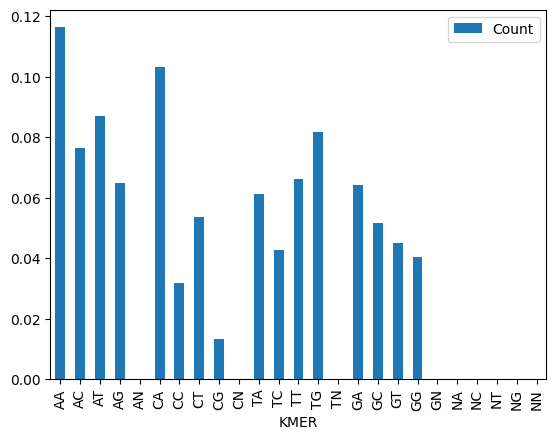

In [90]:
kmer.plot.bar(x='KMER', y='Count')

In [28]:
import numpy as np
kmer_table = np.zeros((4, 4**(k-1)), dtype=np.float32)
kmer_list =[''.join(x) for x in  product('ACTG', repeat= k-1 )]
for mer in _k_mer_iter(contig, k, stride):
    kmer_table['ACTG'.index(mer[0])][kmer_list.index(mer[1:])] += 1
    
    
total = kmer_table.sum()
